## One Day Stock Price Prediction

The codes below try to predict the daily adjusted closing prices (p_close) of Vanguard Total Stock Market ETF (VTI), using data from the previous N days (ie. forecast horizon=1).

### What kind of investment problem can this really address?

The only thing it appears to be good at is for day trading. If the algorithm can accurately predict a stock's closing price based on historical data, then the trader can implement the following trading strategy:

1. Buy the ETF if its price is lower than p_close, then sell it around market closing
2. Short the ETF if its price is higher than p_close, then close the short position around market closing

### What is the success threshold?

Assuming a trader only buys the ETF when the ETF is 5% lower the predicted p_close, he will make money long term if MAPE (Mean Absolute Percentage Error) is 5% or lower.

However, this does not take into account scenario whereby the ETF suffers a catastrophic one day price drop, which can wipe out the trader's capital.



In [16]:
import math
import platform
import matplotlib
import torch
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import time

from datetime import date, datetime, time, timedelta

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))

Python version:  3.6.6
Pytorch version: 1.1.0


In [8]:
#### Input params ##################
stk_path = "VTI.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [9]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Import Stock Price Dataset

In [10]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2015-01-02,106.489998,106.720001,105.269997,105.919998,96.210144,5298300,1
1,2015-01-05,105.349998,105.550003,103.860001,104.099998,94.556976,5383500,1
2,2015-01-06,104.400002,104.500000,102.510002,103.080002,93.630486,4226100,1
3,2015-01-07,104.089996,104.449997,103.550003,104.309998,94.747711,3661500,1
4,2015-01-08,105.209999,106.239998,105.110001,106.150002,96.419029,2796200,1
5,2015-01-09,106.320000,106.349998,104.919998,105.269997,95.619720,3272500,1
6,2015-01-12,105.550003,105.550003,104.120003,104.519997,94.938469,3705900,1
7,2015-01-13,105.330002,106.000000,103.430000,104.279999,94.720467,2936200,1
8,2015-01-14,103.040001,103.790001,102.500000,103.709999,94.202705,3291600,1
9,2015-01-15,104.050003,104.260002,102.570000,102.660004,93.248978,5615200,1


Text(0,0.5,'USD')

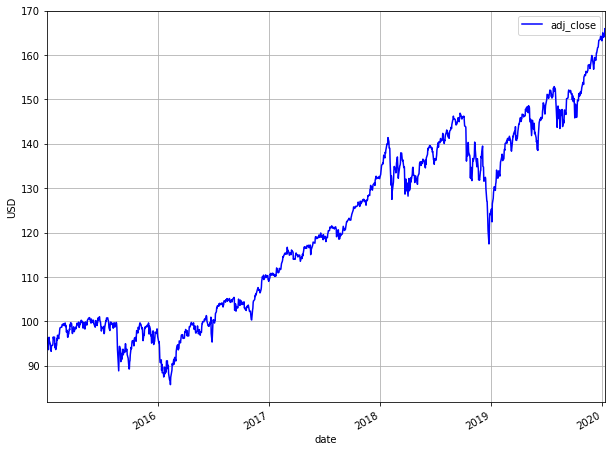

In [11]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [50]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

In [12]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 759
num_cv = 253
num_test = 253
train.shape = (759, 8)
cv.shape = (253, 8)
train_cv.shape = (1012, 8)
test.shape = (253, 8)


Text(0,0.5,'USD')

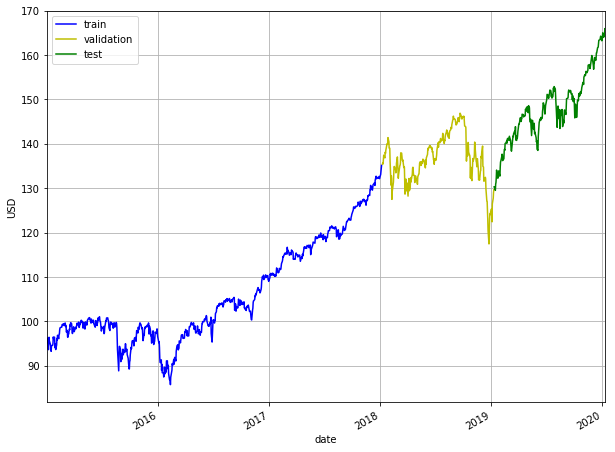

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [33]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [1.433519905206166, 1.6049579044329614, 1.7775072355210113, 1.9645594251658924, 2.131908226687155, 2.280608755225782, 2.4213577868368388, 2.557119307718253, 2.6733098509724917, 2.77623727689924, 2.8669369399148152, 2.9495483786357037, 3.025831416528848, 3.0968370448781863, 3.1575686101936276, 3.209357733175118, 3.258419897673243, 3.30926858625706, 3.361933575734413, 3.414691011612301, 3.4642921862441596]
MAPE = [0.7507483299576122, 0.8670745250754749, 0.9852628952683746, 1.1020578381556259, 1.1883124202743, 1.253980563517156, 1.332591690863887, 1.414010110649646, 1.4883029416043967, 1.5502556809997645, 1.5986708766016968, 1.6411057299150025, 1.6781888452063716, 1.713592102654788, 1.747441481265941, 1.7842168608874553, 1.8215272811178407, 1.8619068529012988, 1.901791892268381, 1.9431234450206514, 1.9809182902788003]


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/use

,date,open,high,low,close,adj_close,volume,month
0,2015-01-02,106.489998,106.720001,105.269997,105.919998,96.210144,5298300,1
1,2015-01-05,105.349998,105.550003,103.860001,104.099998,94.556976,5383500,1
2,2015-01-06,104.400002,104.500000,102.510002,103.080002,93.630486,4226100,1
3,2015-01-07,104.089996,104.449997,103.550003,104.309998,94.747711,3661500,1
4,2015-01-08,105.209999,106.239998,105.110001,106.150002,96.419029,2796200,1


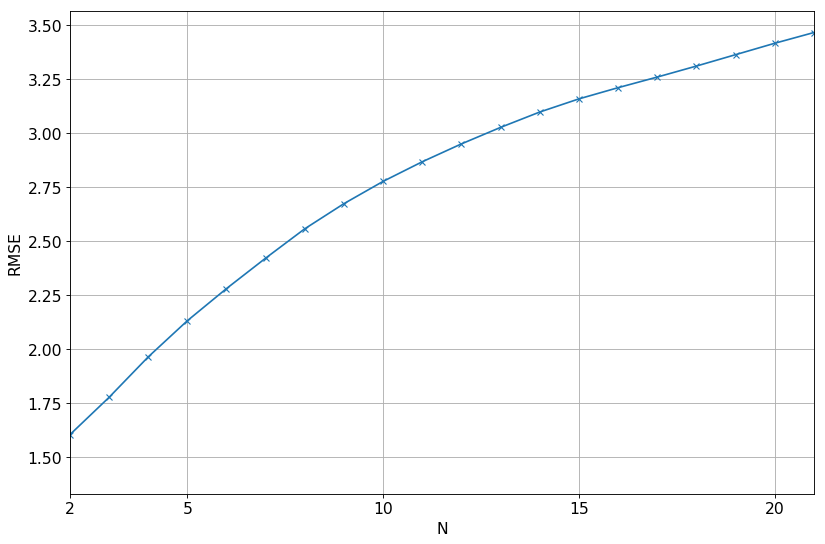

In [34]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

## 

([<matplotlib.axis.XTick at 0x7fbb9962d748>,
 <a list of 5 Text xticklabel objects>)

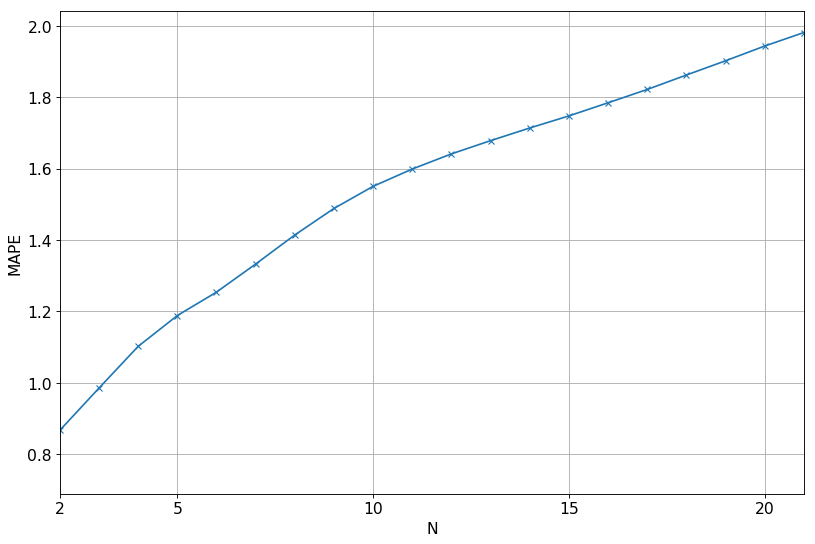

In [35]:

# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

Text(0,0.5,'USD')

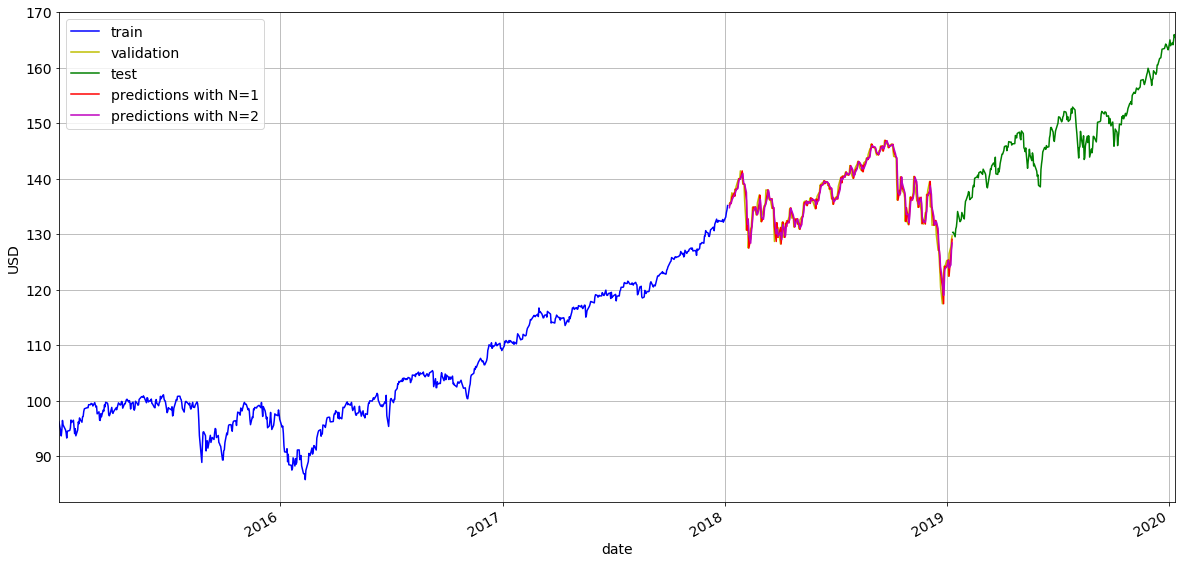

In [36]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 20, 10 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5,1,'Zoom in to dev set')

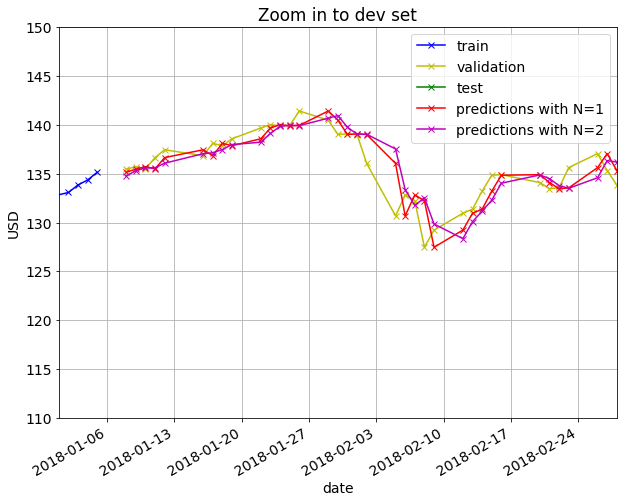

In [47]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 1, 1), date(2018, 2, 28)])
ax.set_ylim([110, 150])
ax.set_title('Zoom in to dev set')

In [71]:
N_opt = 10

est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 2.087
MAPE = 1.192%


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,date,open,high,low,close,adj_close,volume,month,est_N2,est_N20,est_N1,est_N10
1012,2019-01-10,131.440002,132.889999,131.000000,132.809998,130.299591,2685700,1,129.357735,126.171294,129.661880,125.718842
1013,2019-01-11,132.130005,132.860001,131.850006,132.839996,130.329025,3033800,1,129.980736,126.101553,130.299591,126.439948
1014,2019-01-14,131.789993,132.490005,131.559998,132.000000,129.504898,2479400,1,130.314308,125.995733,130.329025,127.053135
1015,2019-01-15,132.190002,133.559998,132.050003,133.440002,130.917664,4542100,1,129.916962,125.864799,129.504898,127.599605
1016,2019-01-16,133.669998,134.330002,133.610001,133.820007,131.290497,2963100,1,130.211281,125.918622,130.917664,128.169622


Text(0,0.5,'USD')

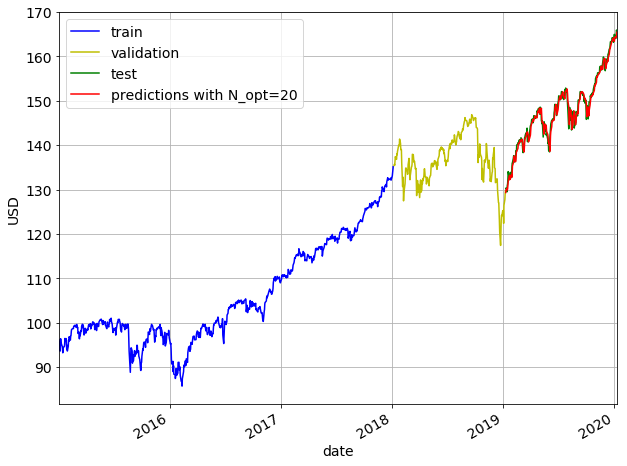

In [72]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=20'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5,1,'Zoom in to test set')

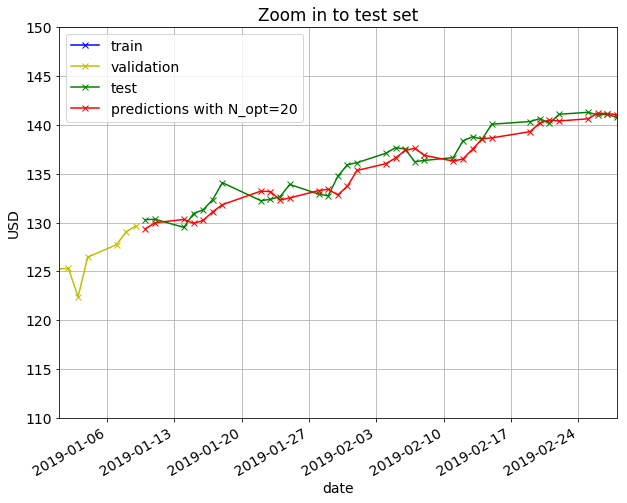

In [73]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=20'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 1, 1), date(2019, 2, 28)])
ax.set_ylim([110, 150])
ax.set_title('Zoom in to test set')